In [1]:
import time
import numpy as np 
import healpy as hp
from tqdm import tqdm


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


setting the output map dtype to [dtype('float64')]


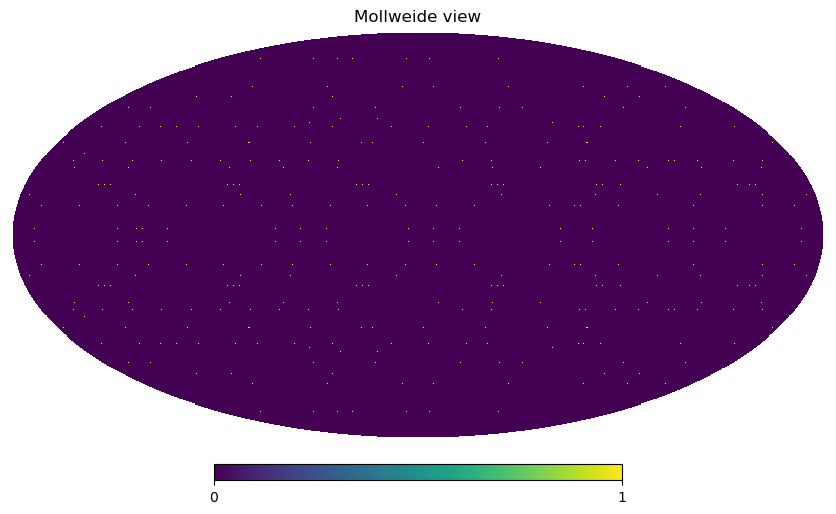

In [2]:
nside1 = 1024
nside2 = 32
map1 = np.zeros(12 * nside1 * nside1)

# Fill the map1 array
for i in range(12 * 32 * 32):
    vec1 = hp.pix2vec(32, i,nest=True)
    pix = hp.vec2pix(1024, vec1[0], vec1[1], vec1[2],nest=True)
    map1[pix] = 1

# Write the map1 array to a FITS file
hp.write_map("map1.fits", map1, overwrite=True,nest=True)
hp.mollview(map1,nest=True)

In [3]:

def RVector(t):
    theta1 = 7.5*np.pi / 180
    theta2 = 85*np.pi / 180
    w1 = 2*np.pi / 60 #rad/sec
    w2 = 2*w1 #rad/sec
    w3 = 3.14159 / 60 #rad/sec
    
    A=[[np.cos(w1*t),np.sin(w1*t),0],
       [-np.sin(w1*t),np.cos(w1*t),0],
       [0,0,1]]
    
    B=[[1,0,0],
       [0,np.cos(w2*t),np.sin(w2*t)],
       [0,-np.sin(w2*t),np.cos(w2*t)]]
    
    C=[[np.cos(theta1),0,np.sin(theta1)],
       [0,1,0],
       [-np.sin(theta1),0,np.cos(theta1)]]
    
    D=[[np.cos(theta2)],
       [np.sin(theta2)*np.cos(w3*t)],
       [np.sin(theta2)*np.sin(w3*t)]]
    
    result1 = np.matmul(A,B)
    result2 = np.matmul(result1,C)
    result = np.matmul(result2,D)

    return result

def SVector(t):
    theta1 = 7.5*np.pi / 180
    theta2 = 0
    w1 = 2*np.pi / 60 #rad/sec
    # w1 = 0.000011954 / 60 #rad/sec
    w2 = 2*w1  #rad/sec
    w3 = 3.14159 / 60 #rad/sec
    
    A=[[np.cos(w1*t),np.sin(w1*t),0],
       [-np.sin(w1*t),np.cos(w1*t),0],
       [0,0,1]]
    
    B=[[1,0,0],
       [0,np.cos(w2*t),np.sin(w2*t)],
       [0,-np.sin(w2*t),np.cos(w2*t)]]
    
    C=[[np.cos(theta1),0,np.sin(theta1)],
       [0,1,0],
       [-np.sin(theta1),0,np.cos(theta1)]]
    
    D=[[np.cos(theta2)],
       [-np.sin(theta2)*np.cos(w3*t)],
       [-np.sin(theta2)*np.sin(w3*t)]]
    
    result1 = np.dot(A,B)
    result2 = np.dot(C,D)
    result = np.dot(result1,result2)
    return result
    
# angular saperation between two pixel
def ang_distance(theta1,theta2,phi1,phi2):
    # cos(∆θ) = sin(θ1)sin(θ2)cos(φ1 - φ2) + cos(θ1)cos(θ2)
    theta = np.arccos(np.cos(theta1) * np.cos(theta2) + np.sin(theta1) * np.sin(theta2) * np.cos(phi1 - phi2))
    return theta


def process_time_step(time_step):
    
    t = time_step  

    # 1. Calculate R(t) and S(t) vectors
    R = RVector(t)
    S = SVector(t)

    # 2. Calculate pixel number along R(t) vector (ring format)
    theta_R, phi_R = hp.vec2ang(R)
    pic_ring = hp.ang2pix(nside, theta=theta_R, phi=phi_R)

    # 3. Convert to NEST format
    nest_pix = hp.ring2nest(nside, pic_ring)

    # 4. Find neighboring pixels in NEST format
    # neighbours = hp.get_all_neighbours(nside, nest_pix,nest=True)
    neighbours = hp.query_disc(nside, R , radius=np.radians(0.75),nest = True)

    # 5. angular separation central pixel to neighbor
    theta_separations = np.zeros_like(neighbours)
    for i, neighbour_pix in enumerate(neighbours):
        theta_neighbour, phi_neighbour = hp.pix2ang(nside, neighbour_pix)
        theta_separations[i] = ang_distance(theta_R, theta_neighbour, phi_R, phi_neighbour) 

    # 6. Retrieve temperatures of neighboring pixels
    neighbor_temperatures = temperature_map[neighbours]

    # 7. Apply the beam convolution
    convolved_temperature = np.sum(neighbor_temperatures * np.exp(-theta_separations**2 / (2 * sigma**2))) / np.sum(np.exp(-theta_separations**2 / (2 * sigma**2)))

    return int(nest_pix),convolved_temperature


In [4]:
theta1 = 7.5*np.pi / 180
theta2 = 85*np.pi / 180
w1 = 2*np.pi / 60 #rad/sec
w2 = 2*w1 #rad/sec
w3 = 3.14159 / 60 #rad/sec

nside=1024
npix = 12*nside**2

# time_step=scan_time
scan_time = np.sqrt(4*np.pi/npix)/w1
fwhm=45 # Example (in degree)
sigma = fwhm / np.sqrt(8 * np.log(2)) 

temperature_map = hp.read_map("map1.fits", nest=True)

In [5]:
start = time.time()

start_time=0
duration = 60 #in sec
steps = int(duration / scan_time)

time_periods = np.linspace(start_time, start_time + steps*scan_time, steps)
time_periods_iterator = tqdm(time_periods, desc="Processing", total=len(time_periods))
with open("temperature.dat", "a") as f:  
    for time_period in time_periods_iterator:  # Iterate over the tqdm object
        pixel,temperature = process_time_step(time_period)
        f.write(f"{time_period:.4f} {pixel} {temperature}\n")


end = time.time()
elapsed_time = end - start
print(f"Total execution time: {elapsed_time:.2f} seconds")

Processing:   0%|                                      | 0/6287 [00:00<?, ?it/s]/tmp/ipykernel_63925/345974403.py:83: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  neighbours = hp.query_disc(nside, R , radius=np.radians(0.75),nest = True)
/tmp/ipykernel_63925/345974403.py:89: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  theta_separations[i] = ang_distance(theta_R, theta_neighbour, phi_R, phi_neighbour)
/tmp/ipykernel_63925/345974403.py:97: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Depr

Total execution time: 41.63 seconds


In [ ]:
# 1. Load the data
data = np.loadtxt("temperature1.dat")
pixels, temperatures4 = data[:, 1].astype(int), data[:, 2]

# 2. Create a Healpix map with zeros
map_array = np.zeros(npix)
# map_array = hp.read_map("map1.fits", nest=True)

# 3. Fill in available pixels with temperatures
map_array[pixels] = temperatures4
# map=np.linspace(0, npix, npix)

hp.mollview(map_array,nest=True, title="Convolved Temperature Map", unit="K")
# hp.graticule()
plt.savefig("convolved_temperature_map.png")
plt.show()